In [1]:
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('~')
from analysts_tools.growth import *
    #Procurement tools
from analystcommunity.read_connection_data_warehouse import run_read_dwd_query
from analysts_tools.redash_methods import *
from procurement_lib import redash, dw, send_message, send_slack_notification, GoogleSheet, logging

import random
import time
import datetime

In [2]:
city = 'BHZ'

In [3]:
query = """
SELECT
    s.identifier_value AS region_code,
    --fs.order_submitted_date AS fecha,
    --fs.order_id,
    dc.source_id AS customer_id,
    cat.parent_description AS cat,
    cat.description AS subcat,
    dp.card_id,
    --dp.card_description AS product_name,
    --COUNT(DISTINCT dp.card_id) AS skus,
    SUM(fs.gmv_pxq_local)/4.75 AS gmv_usd,
    SUM(COALESCE(fsd.product_discount,0))/4.75 AS discount_applied,
    100.00*discount_applied/gmv_usd AS per_dct,
    (1-(SUM(cogs_p_mtd*fs.product_quantity_x_step_unit)/SUM(fs.product_price*fs.product_quantity_x_step_unit)))*100.00 AS margin,
    gmv_usd*margin/100.00 AS cash_margin,
    cash_margin-discount_applied AS net_cash_margin,
    100.00*net_cash_margin/gmv_usd AS net_margin,
    100.00*SUM((product_price*fs.product_quantity_x_step_unit)+fs.product_tax_iva)/SUM(pb.min_price*fs.product_quantity_x_step_unit) AS gpi,
    100.00*SUM((product_price_discount*fs.product_quantity_x_step_unit)+fs.product_tax_iva)/SUM(pb.min_price*fs.product_quantity_x_step_unit) AS npi

FROM dpr_sales.fact_sales                   fs
INNER JOIN dpr_shared.dim_customer          dc  ON dc.customer_id = fs.dim_customer
INNER JOIN dpr_shared.dim_site              s   ON s.site_id = fs.dim_site
INNER JOIN dpr_shared.dim_product           dp  ON dp.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_category          cat ON cat.category_id = dp.category_id
LEFT JOIN dpr_sales.fact_sales_discounts    fsd ON fs.order_item_id = fsd.order_item_id 
INNER JOIN dpr_shared.dim_stock_unit        su  ON su.product_id = fs.dim_product
INNER JOIN dpr_shared.dim_stock_unit        sup  ON nvl(nullif(su.source_parent_id,0),su.source_id) = sup.source_id
LEFT JOIN dpr_cross_business.fact_cross_business_insights m ON m.dim_stock_unit = sup.stock_unit_id AND m.dim_date = fs.dim_submitted_date
LEFT JOIN dpr_product_pricing.obt_benchmark_product_prices  pb  ON pb.stock_unit_id = sup.stock_unit_id AND DATE(fs.order_submitted_date) = pb.benchmark_date

WHERE 
    fs.gmv_enabled = TRUE
    AND fulfillment_order_status NOT IN ('CANCELLED', 'ARCHIVED','No value')
    AND fs.fb_order_status_id IN (1,6,7,8)
    AND fs.is_deleted = FALSE
    AND fs.dim_status = 1
    AND dp.is_slot = 'false'
    AND fs.gmv_pxq_local > 0
    AND s.identifier_value = '{city}'
    AND DATE(fs.order_submitted_date) >= DATE(current_date) - 60
GROUP BY 1,2,3,4,5
HAVING gpi < 150 AND gpi > 50
""".format(city=city)

df_sells = run_read_dwd_query(query)

In [4]:
### THIS df GENERETE THE WHOLE DATA OF OUR CUSTOMERS TO GET SEGMENTED LATER
query = """
SELECT
  source_id AS customer_id,
  email_address AS email,
  CASE 
  WHEN is_kam_audited THEN 'KAM'
  WHEN is_graduated THEN 'GRAD'
  ELSE 'FARM'END AS grupo,
  last_order_city,
  recency_days,
  microsegment_name,
  business_type
  
FROM dpr_customer.obt_customer

WHERE last_order_city = '{city}'
 AND source_id IN {clientes}
""".format(city=city, clientes=tuple(df_sells.customer_id.unique()))
df_customers = run_read_dwd_query(query)

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [6]:
df =  pd.merge(df_sells, df_customers[['customer_id','grupo','business_type']], left_on=['customer_id'], right_on=['customer_id'], how='left')
df = df.dropna()

In [7]:
df.columns

Index(['region_code', 'customer_id', 'cat', 'subcat', 'card_id', 'gmv_usd',
       'discount_applied', 'per_dct', 'margin', 'cash_margin',
       'net_cash_margin', 'net_margin', 'gpi', 'npi', 'grupo',
       'business_type'],
      dtype='object')

In [9]:
#df = df.loc[(df.subcat == 'Cervejas') & (df.grupo != 'KAM') & (df.business_type != 'Hogar')].reset_index(drop=True).copy()
df = df.loc[ 
                (df['grupo'] != 'KAM') & 
                (df['business_type'] != 'Hogar')].groupby(['customer_id']).agg(
    gmv_usd=('gmv_usd', np.sum),
    discount_applied=('discount_applied', np.sum),
    card_id=('card_id', 'nunique'),
    cash_margin=('cash_margin', np.sum),
    net_cash_margin=('net_cash_margin', np.sum),
    gpi=('gmv_usd', lambda x: np.sum(x * df['gpi']) / np.sum(x)),
    npi=('gmv_usd', lambda x: np.sum(x * df['npi']) / np.sum(x))
).reset_index()
#df = df.loc[df.card_id == 293209].reset_index(drop=True).copy()

In [10]:
df

,customer_id,gmv_usd,discount_applied,card_id,cash_margin,net_cash_margin,gpi,npi
0,59556171,106.9323,1.2673,6,12.823054,11.555754,102.3747605789831510217212199,101.1794515265265967345694425
1,63773239,5167.7546,75.8353,29,690.357451,614.522151,108.1649782854839895067772762,106.4973446912281786755121847
2,63775372,354.5928,7.1072,19,61.380897,54.273697,104.3225692656478078517104690,102.1620232283622228088105568
3,63785947,221.9128,6.2754,19,49.120671,42.845271,102.3923578811136626638932049,99.52785272435839663146965835
4,63790041,261.8998,8.7469,28,53.036363,44.289463,106.6158457214553046623174206,103.0066559849224779858556593
...,...,...,...,...,...,...,...,...
5500,370909950,195.7680,6.4335,7,18.818968,12.385468,103.6673181912263495566180377,99.98084069536390012668056066
5501,370910841,69.5240,1.3641,3,8.717697,7.353597,104.6843637149761233530867039,102.6336321701858351073010759
5502,370916635,44.2145,0.3410,5,5.954439,5.613439,109.0058654464033292245756483,108.1534140438091576292845107
5503,370920817,160.7663,0.0000,1,20.176170,20.176170,108.8240,108.8240


In [11]:
# Assuming you have a DataFrame called 'df' with columns 'net_cash_margin' and 'gmv'
# Select the relevant columns
selected_columns = ['net_cash_margin', 'gmv_usd']
df_selected = df[selected_columns]

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

In [23]:
# # Determine the optimal number of clusters using the Elbow method
# inertia = []
# for k in range(1, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df_scaled)
#     inertia.append(kmeans.inertia_)
    
# # Plot the Elbow curve
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 11), inertia, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.grid(True)
# plt.show()

In [24]:
# # Determine the optimal number of clusters using the Silhouette score
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df_scaled)
#     silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# # Plot the Silhouette scores
# plt.figure(figsize=(8, 6))
# plt.plot(range(2, 11), silhouette_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score for Optimal K')
# plt.grid(True)
# plt.show()

In [12]:
# Based on the Elbow curve, choose an appropriate value for K (number of clusters)
# Let's assume you choose K=3
k = 3

# Fit KMeans with the chosen K
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

In [13]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

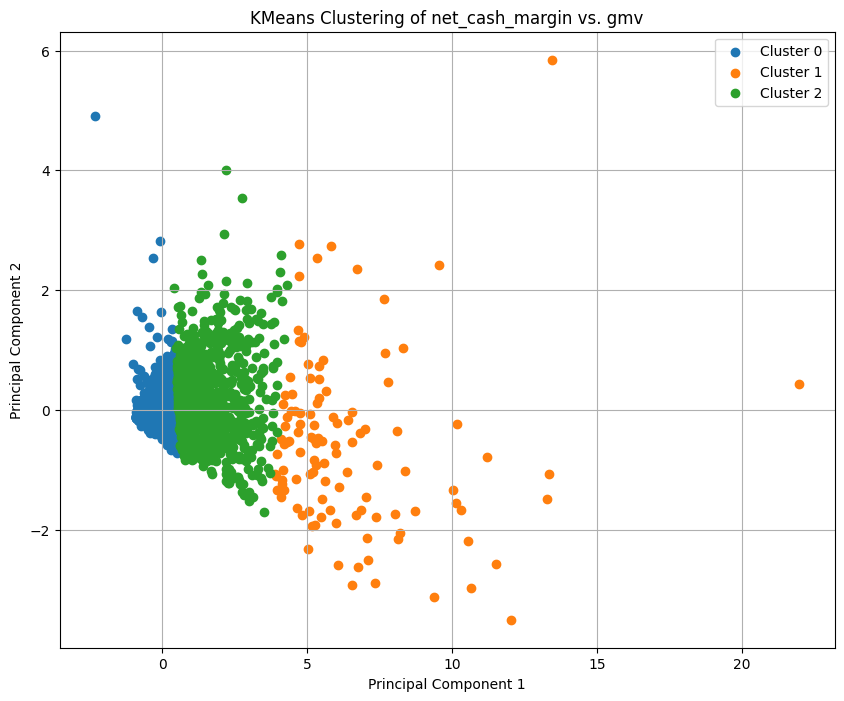

         net_cash_margin      gmv_usd         gpi         npi
cluster                                                      
0              26.028833   278.013377  107.387264  103.430758
1             637.644033  3673.668176  110.955146  108.270189
2             175.102905  1498.271556  108.478036  104.919496


In [14]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df_pca[df['cluster'] == i, 0], df_pca[df['cluster'] == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of net_cash_margin vs. gmv')
plt.legend()
plt.grid(True)
plt.show()

# You can further analyze the characteristics of each cluster
cluster_summary = df.groupby('cluster')[['net_cash_margin','gmv_usd','gpi','npi']].mean()
print(cluster_summary)

In [20]:
cluster_summary = df[['net_cash_margin','gmv_usd','gpi','npi']].mean()
print(cluster_summary)

net_cash_margin     63.469630
gmv_usd            551.424142
gpi                107.642594
npi                103.778625
dtype: float64


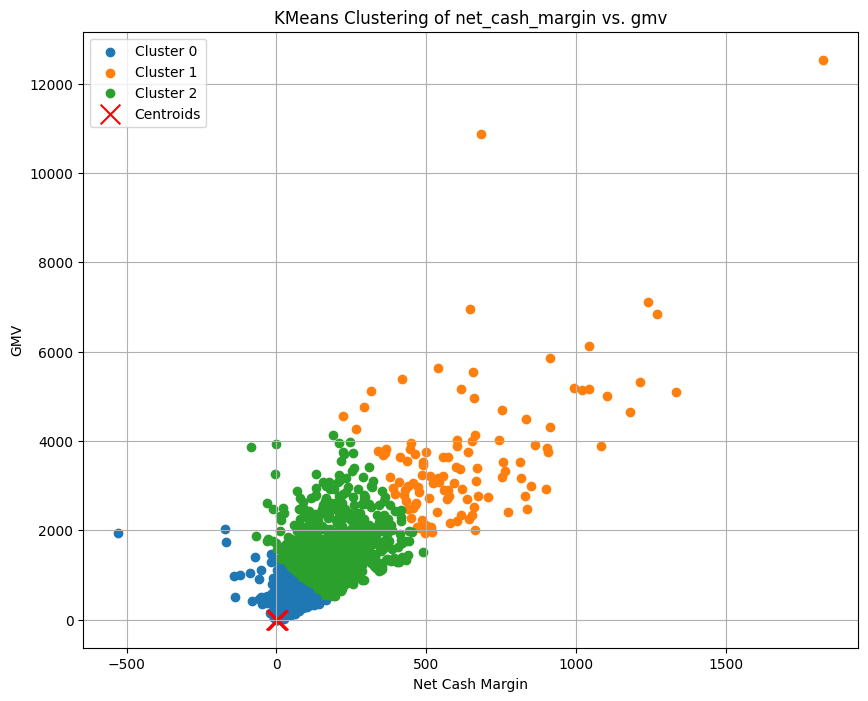

In [15]:
# Visualize the clusters without PCA
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(df['net_cash_margin'][df['cluster'] == i], df['gmv_usd'][df['cluster'] == i], label=f'Cluster {i}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red', s=200, label='Centroids')
plt.xlabel('Net Cash Margin')
plt.ylabel('GMV')
plt.title('KMeans Clustering of net_cash_margin vs. gmv')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df.cluster.value_counts()

0    4473
2     919
1     113
Name: cluster, dtype: int64

In [17]:
df.loc[df.cluster == 0].sort_values(by=['gmv_usd'],ascending=False)#.head(20)

,customer_id,gmv_usd,discount_applied,card_id,cash_margin,net_cash_margin,gpi,npi,cluster
1309,156258035,2019.6691,350.8923,12,179.232443,-171.659857,105.6538856426926569307813839,86.77974036361203921969197826,0
3190,345493637,1934.3746,717.6420,6,190.188901,-527.453099,108.7090539230302134860538388,68.46025478764040842968057997,0
1158,145907189,1737.8560,321.0878,17,152.349201,-168.738599,105.7101215553532628710318922,85.70064548587454886941150475,0
4040,358330894,1461.4229,119.0146,7,100.444751,-18.569849,100.8232926374152204676688726,92.56775438421691626701620729,0
1906,187637959,1410.3864,211.0562,19,138.013154,-73.043046,103.2028577900495920834177074,87.44996971364726716026189702,0
...,...,...,...,...,...,...,...,...,...
3057,338152740,6.5789,0.0631,1,0.895388,0.832288,114.0510,112.9562,0
601,103844802,5.3136,0.3494,2,1.968676,1.619276,137.6361898204607046070460705,128.5425253406353507979524240,0
4443,362337678,2.7978,0.0000,2,0.902659,0.902659,136.8017485846021874329830581,136.8017485846021874329830581,0
5446,370563496,2.7031,0.0000,1,0.790116,0.790116,116.7272,116.7272,0
